### Steps to re-run the given code for training a new model:
**Step 1.** Mount your google drive.

**Step 2.** Add the paths to your test, train and validation csv files.  

**Step 3.** Add the path to your image folder.  

**Step 4.** Run each cell to regenerate a new model.

**Step 5.** Save the model by running the cell with the code to save model and add the path to the saved_model variable to produce the evaluation metrics.


In [1]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
from keras.utils import image_dataset_from_directory
import tensorflow as tf

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_csv_path = '/content/drive/MyDrive/classification_aircraft/train.csv'
test_csv_path = '/content/drive/MyDrive/classification_aircraft/test.csv'
val_csv_path = '/content/drive/MyDrive/classification_aircraft/val.csv'

In [4]:
# Path to image directory
image_dir = '/content/drive/MyDrive/classification_aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/'

In [5]:
# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
val_df = pd.read_csv(val_csv_path)

In [6]:
train_df['filename'] = image_dir + train_df['filename']
test_df['filename'] = image_dir + test_df['filename']
val_df['filename'] = image_dir + val_df['filename']

In [8]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define a function to load and preprocess images
def preprocess_image(filename, label):
    # Read and decode the image file
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)

    # Apply random horizontal flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Resize the image
    image = tf.image.resize(image, [512, 512])

    # Normalize the pixel values
    image = image / 255.0  # Rescale pixel values to [0, 1]

    return image, label

# Create a TensorFlow Dataset from the dataframe
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['filename'], train_df['Labels']))

# Map the preprocess function to each sample in the dataset
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch the dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_df)).batch(batch_size)

# Prefetch the data
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Check if the dataset is correctly created
print(train_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [9]:
# Create a function to load and preprocess images for test and validation sets
def preprocess_image_test_val(filename, label):
    # Read and decode the image file
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust channels as per your images

    # Resize the image
    image = tf.image.resize(image, [512, 512])  # Resize dimensions as per your requirement

    # Normalize the pixel values
    image = image / 255.0  # Rescale pixel values to [0, 1]

    return image, label

# Create datasets for test and validation sets
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['filename'], test_df['Labels']))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['filename'], val_df['Labels']))

# Map the preprocess function to each sample in the test and validation datasets
test_dataset = test_dataset.map(preprocess_image_test_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image_test_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the test and validation datasets
batch_size = 32
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Prefetch the data
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



In [11]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.3 MB/s eta 0:00:00


In [12]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define a function to build the model
def build_model(hp):
    base_model = InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(512, 512, 3)
    )
    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=hp.Int('units', min_value=256, max_value=1024, step=256), activation='relu'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.5, max_value=0.9, step=0.2)),
        Dense(units=hp.Int('units', min_value=256, max_value=1024, step=256), activation='relu'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.5, max_value=0.9, step=0.2)),
        Dense(100, activation='softmax')
    ])

    # Define the optimizer
    optimizer = Adam(learning_rate=0.0001)  # Learning rate set to 0.0001 for the scheduler

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the RandomSearch tuner to search for the best hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Total number of trials (model configurations) to test
    directory='my_dir',  # Directory to save the search results
    project_name='hyperparameter_tuning'  # Name for the project
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(train_dataset,
             epochs=50,
             validation_data=val_dataset,
             batch_size=[32, 64],  # Batch size to be tuned
             callbacks=[early_stopping])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hp}")


Trial 5 Complete [00h 48m 15s]
val_accuracy: 0.6807680726051331

Best val_accuracy So Far: 0.798079788684845
Total elapsed time: 02h 16m 54s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7e3b6c8345e0>


In [17]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print("Units:", best_hp.get('units'))
print("Dropout:", best_hp.get('dropout'))


Best Hyperparameters:
Units: 1024
Dropout: 0.5


In [19]:
# Set random seeds for reproducibility
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
from keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = tf.keras.applications.inception_v3.InceptionV3(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(512,512,3)
                     )

base_model.trainable=True

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(100, activation='softmax')
    ])



In [21]:
optim = Adam(learning_rate=0.0001)
# The model optimises cross entropy as its loss function and will monitor classification accuracy:
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_190 (B  (None, 1024)              4096      
 atchNormalization)                                              
                                                                 
 activation_190 (Activation  (None, 1024)              0         
 )                                                               
                                                      

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, batch_size=32, callbacks=[lr_scheduler, early_stopping])


Epoch 1/50
105/105 [==============================] - 99s 522ms/step - loss: 5.5366 - accuracy: 0.0144 - val_loss: 4.5640 - val_accuracy: 0.0288 - lr: 1.0000e-04
Epoch 2/50
105/105 [==============================] - 68s 508ms/step - loss: 4.9085 - accuracy: 0.0330 - val_loss: 4.2083 - val_accuracy: 0.0783 - lr: 1.0000e-04
Epoch 3/50
105/105 [==============================] - 69s 507ms/step - loss: 4.4945 - accuracy: 0.0654 - val_loss: 3.7590 - val_accuracy: 0.1659 - lr: 1.0000e-04
Epoch 4/50
105/105 [==============================] - 68s 507ms/step - loss: 3.9770 - accuracy: 0.1245 - val_loss: 3.4038 - val_accuracy: 0.2211 - lr: 1.0000e-04
Epoch 5/50
105/105 [==============================] - 69s 508ms/step - loss: 3.5159 - accuracy: 0.1878 - val_loss: 2.9121 - val_accuracy: 0.3066 - lr: 1.0000e-04
Epoch 6/50
105/105 [==============================] - 69s 507ms/step - loss: 3.1244 - accuracy: 0.2531 - val_loss: 2.6039 - val_accuracy: 0.3612 - lr: 1.0000e-04
Epoch 7/50
105/105 [========

In [23]:
_, acc = model.evaluate(test_dataset, verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))

105/105 [==============================] - 171s 2s/step - loss: 0.6567 - accuracy: 0.8308
Accuracy: 83.078


In [24]:
import tensorflow as tf

# Define the file path where you want to save the model
model_path = 'my_model.h5'

# Save the model
tf.keras.models.save_model(model, model_path)

print("Model saved successfully at:", model_path)


<ipython-input-24-b2fe3483bba2>:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_path)


Model saved successfully at: my_model.h5


In [33]:
import tensorflow as tf
import numpy as np

# Load the saved model
model_path = '/content/my_model.h5'
saved_model = tf.keras.models.load_model(model_path)

# Define a function to preprocess a single image
def preprocess_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    image = image / 255.0
    return image

# Fetch 5 images and their labels from the test dataset
test_images_filenames = test_df['filename'].values[:10]
true_labels = test_df['Labels'].values[:10]

# Preprocess the images
test_images = [preprocess_image(filename) for filename in test_images_filenames]
test_images = np.array(test_images)

# Predict the labels for the test images
predictions = saved_model.predict(test_images)

# Extract unique class labels from the 'Labels' column of test_df
class_labels = test_df['Labels'].unique()
predicted_labels = [class_labels[np.argmax(prediction)] for prediction in predictions]

# Print true and predicted labels for each image
for i in range(10):
    print("Image:", test_images_filenames[i])
    print("True Label:", true_labels[i])
    print("Predicted Label:", predicted_labels[i])
    print()


1/1 [==============================] - 3s 3s/step
Image: /content/drive/MyDrive/classification_aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/1514522.jpg
True Label: 0
Predicted Label: 0

Image: /content/drive/MyDrive/classification_aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/0747566.jpg
True Label: 0
Predicted Label: 0

Image: /content/drive/MyDrive/classification_aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/1008575.jpg
True Label: 0
Predicted Label: 0

Image: /content/drive/MyDrive/classification_aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/0717480.jpg
True Label: 0
Predicted Label: 0

Image: /content/drive/MyDrive/classification_aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/0991569.jpg
True Label: 0
Predicted Label: 55

Image: /content/drive/MyDrive/classification_aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/1446335.jpg
True Label: 0
Predicted Label: 17

Image: /content/drive/MyDrive/classi

105/105 [==============================] - 13s 123ms/step
Precision: 0.8379928710572611
Recall: 0.8307830783078308
F1 Score: 0.830309281902489


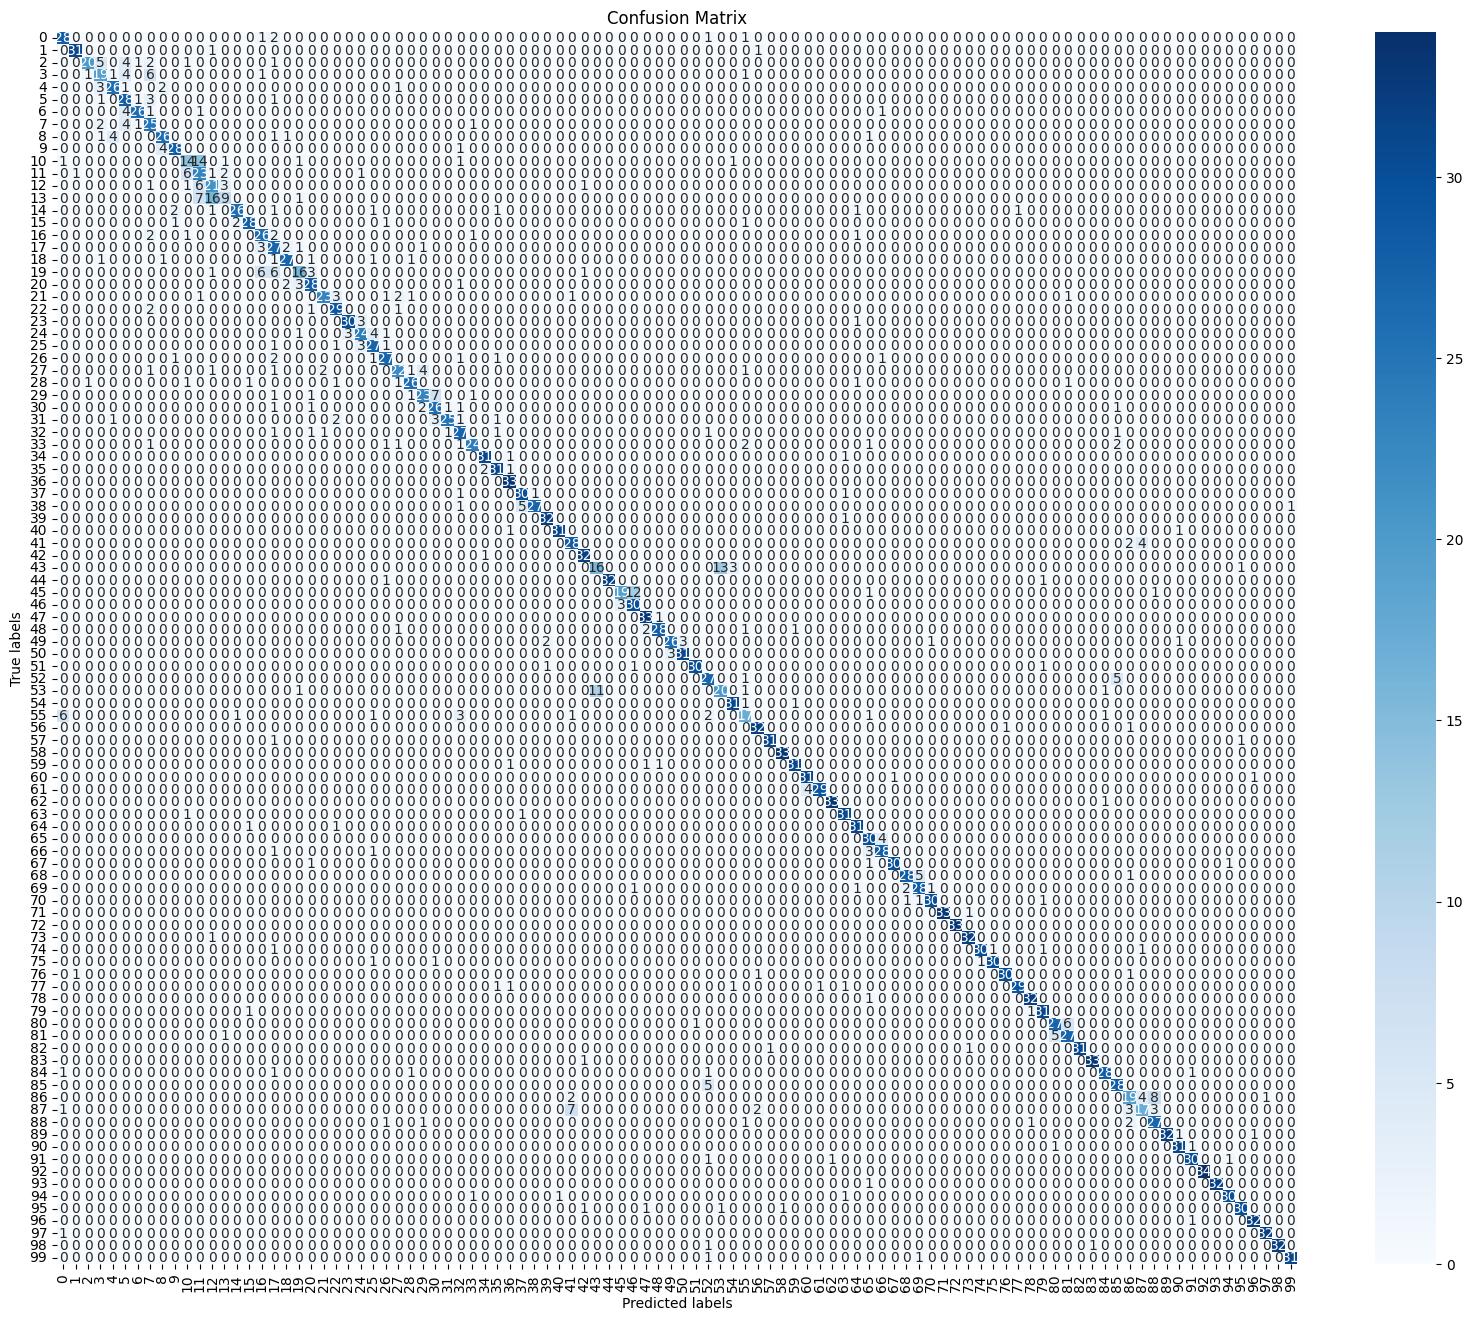

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Get predictions for the test dataset
predictions = saved_model.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels for the test dataset
true_labels = np.concatenate([label.numpy() for _, label in test_dataset])

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [29]:
#to display reproducible accuracy
_, acc = saved_model.evaluate(test_dataset, verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))

105/105 [==============================] - 12s 108ms/step - loss: 0.6567 - accuracy: 0.8308
Accuracy: 83.078
